In [1]:
from fmp_python.fmp import FMP
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np

load_dotenv()
FMP_API_KEY = os.getenv("FMP_API_KEY")
fmp = FMP(output_format='pandas',api_key=FMP_API_KEY)

## Module 1 - Visualizing and Munging Stock Data

In [2]:
ms = fmp.get_historical_price("MSFT")
fb = fmp.get_historical_price("META")

ms['date'] = pd.to_datetime(ms['date'],yearfirst=True)
fb['date'] = pd.to_datetime(fb['date'],yearfirst=True)

ms = ms.set_index('date')
fb = fb.set_index('date')

fb = fb.sort_index()
ms = ms.sort_index()

In [3]:
fb['price_diff'] = fb['close'].shift(-1) - fb['close'] #shift(-1)

In [4]:
fb['daily_return'] = fb['price_diff'] / fb['close']

In [5]:
fb['direction'] = 0
fb.loc[fb['price_diff']>0,'direction'] = 1
fb.loc[fb['price_diff']<=0,'direction'] = -1

In [6]:
fb['rolling_10'] = fb['close'].rolling(window='10D').mean() #fast signal
fb['rolling_20'] = fb['close'].rolling(window='20D').mean() #previous practice
fb['rolling_50'] = fb['close'].rolling(window='50D').mean() #slow signla

<Axes: xlabel='date'>

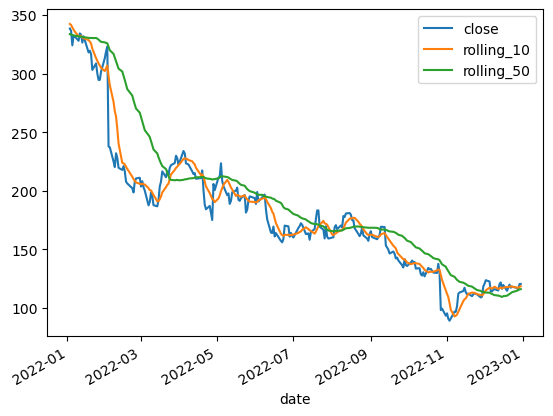

In [7]:
fb_2022 = fb.iloc[fb.index.year == 2022]

fb_2022[['close','rolling_10','rolling_50']].plot()

<Axes: xlabel='date'>

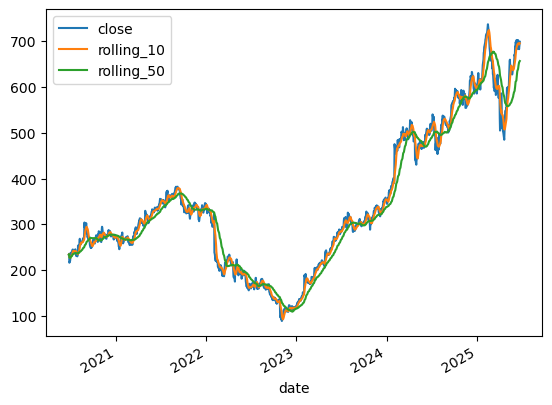

In [8]:
fb[['close','rolling_10','rolling_50']].plot()

In [9]:
#Trading Strategy:
#If rolling_10 > rolling_50 -> buy and hold (long)

fb['shares'] = [1 if fb.loc[ei,'rolling_10']>fb.loc[ei,'rolling_50'] else 0 for ei in fb.index]

In [10]:
fb['profit'] = [fb.shift(-1).loc[ei,'close']-fb.loc[ei,'close'] if fb.loc[ei,'shares'] else 0 for ei in fb.index]

In [11]:
fb['wealth'] = fb['profit'].cumsum()

In [12]:
fb.loc[fb['wealth']< 0] #All spots where wealth was negative

,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,...,changeOverTime,price_diff,daily_return,direction,rolling_10,rolling_20,rolling_50,shares,profit,wealth
date,,,,,,,,,,,,,,,,,,,,,
2020-07-10,243.69,245.49,239.32,245.07,243.73,22982716,22982716,1.38,0.56629,243.3925,...,0.005663,-6.07,-0.024768,-1,240.751429,234.895833,234.895833,1,-6.07,-1.28
2020-07-13,247.01,250.15,238.42,239.00,237.70,24674900,24674900,-8.00,-3.24000,243.6450,...,-0.032400,0.73,0.003054,1,242.215000,235.211538,235.211538,1,0.73,-0.55
2020-07-21,246.22,246.91,240.08,241.75,240.43,19409687,19409687,-4.47,-1.82000,243.7400,...,-0.018200,-1.88,-0.007777,-1,241.305714,241.296154,237.257368,1,-1.88,-0.41
2020-07-22,240.26,241.90,238.12,239.87,238.56,15427900,15427900,-0.39,-0.16232,240.0375,...,-0.001623,-7.27,-0.030308,-1,241.126250,241.792308,237.388000,1,-7.27,-7.68
2020-07-23,239.63,242.42,231.75,232.60,231.33,21771802,21771802,-7.03,-2.93000,236.6000,...,-0.029300,-1.89,-0.008126,-1,240.326250,241.135714,237.160000,1,-1.89,-9.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25,141.22,143.17,140.31,141.50,140.73,26622021,26622021,0.28,0.19827,141.5500,...,0.001983,5.80,0.040989,1,138.830000,136.220769,125.657576,1,5.80,-9.29
2023-01-26,144.40,147.51,143.30,147.30,146.50,25482100,25482100,2.90,2.01000,145.6275,...,0.020100,4.44,0.030143,1,139.888750,137.550000,126.668788,1,4.44,-4.85
2023-01-27,148.24,153.19,147.39,151.74,150.91,35771900,35771900,3.50,2.36000,150.1400,...,0.023600,-4.68,-0.030842,-1,141.936250,138.563571,127.772121,1,-4.68,-9.53


## Module 2 - Random Variables & Distributions

At the end of the previous module our *wealth* went below 0.
We'd like to avoid this as it's related to "bankruptcy", we need to compute the probability of such losses to decide if we have the 'appetite' for such risk occuring

In [13]:
die = pd.DataFrame([1,2,3,4,5,6]) # A six sided dice can implement in pandas as a dataFrame with 6 values (1 through 6)

#.sample() takes from a data frame and returns a new dataFrame with 'randomly' selected entires. replace=True is a parameter that allows for repeaters

trial_1 = die.sample(2,replace=True) # This trial_1 is the result of rolling two independent 6-sided dice, it'll change each time it's ran

We can simulate multiple rolls of two dice by re-running the same code. If we're interested in the sum we can use the Dataframe method *.sum()* and even record the results in an array

In [14]:
trial = 5000
trial_data = pd.DataFrame([die.sample(2,replace=True).sum()[0] for _ in range(trial)]) # now we have 50 'simulated' two dice rolls

In [15]:
# the [0] gives the first column (exclusing index) from the dataFrame
#.value_counts() returns a series with index being the unique values found and the first column being the total count of that index

frequencies = trial_data[0].value_counts()

<Axes: xlabel='0'>

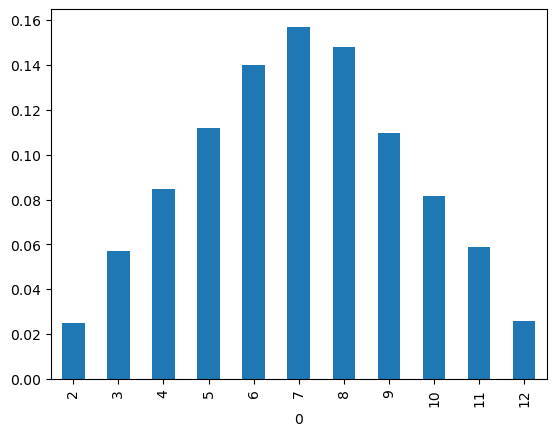

In [16]:
sorted_frequencies = frequencies.sort_index() / trial
sorted_frequencies.plot(kind='bar')

In [17]:
mean_value = (sorted_frequencies.index * sorted_frequencies).sum()

In [18]:
variance = (((sorted_frequencies.index - mean_value) ** 2) * sorted_frequencies).sum()

In [19]:
print(mean_value, variance)

7.0074000000000005 5.800545240000001


In [20]:
ap = fmp.get_historical_price("AAPL")
ap['date'] = pd.to_datetime(ap['date'],yearfirst=True)
ap = ap.set_index('date')
ap = ap.sort_index()

In [21]:
ap['log_return'] = np.log(ap['close']/ap['close'].shift(1))
ap['simple_return'] = ap['close'].pct_change()

<Axes: ylabel='Frequency'>

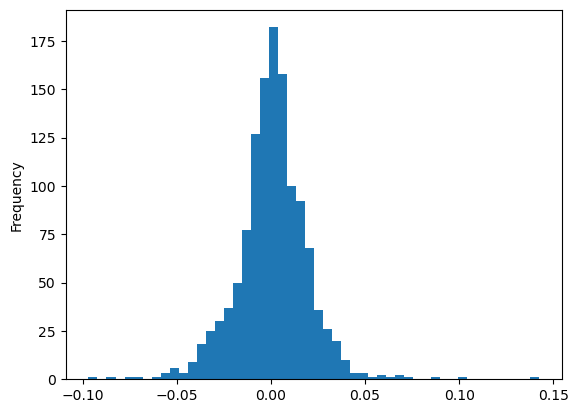

In [22]:
ap['log_return'].plot(kind='hist',bins=50)

In [23]:
from scipy.stats import norm

In [24]:
density = pd.DataFrame()

density['x'] = np.arange(-4,4,0.001)
density['pdf'] = norm.pdf(density['x'])
density['cdf'] = norm.cdf(density['x'])

#Default for norm is loc=0, scale=1, i.e., mean = 0 and std dev = 1

<Axes: xlabel='x'>

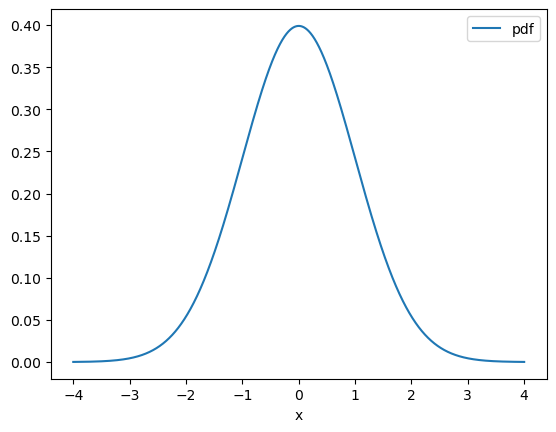

In [25]:
density.plot(x='x',y='pdf')

In [26]:
mu = ap['log_return'].mean()
sigma = ap['log_return'].std()

In [27]:
density_ap = pd.DataFrame()

density_ap['x'] = np.arange(ap['log_return'].min(),ap['log_return'].max(),0.001)
density_ap['pdf'] = norm.pdf(density_ap['x'],loc=mu,scale=sigma)
density_ap['cdf'] = norm.cdf(density_ap['x'],loc=mu,scale=sigma)

<Axes: xlabel='x'>

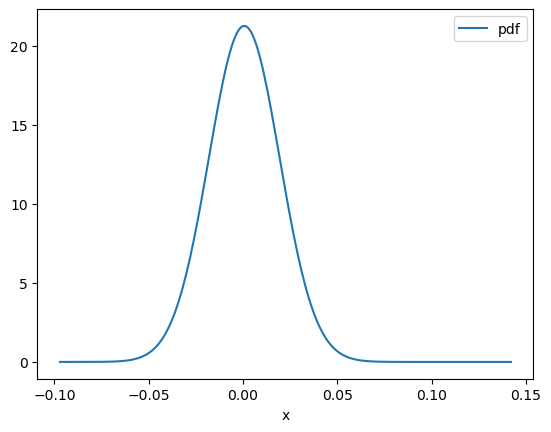

In [28]:
density_ap.plot(x='x',y='pdf')

In [29]:
# norm.expect() calculates the expected value between lb (lower bound) and ub (uppper bound)
# if the function is f(x) = 1, then this corresponds to the area under the distribution
# which is the probability of observing an event between the bounds
# UPDATE: use cdf with a fixed value (duh)
prob_big_loss = norm.cdf(-0.05, loc=mu, scale=sigma)
print(f"The probability of experiencing a daily log return of less than 5% is {prob_big_loss}")

The probability of experiencing a daily log return of less than 5% is 0.003498681886812614


In [30]:
# We can update to the yearly by appropriate scaling (using 220 trading days in a year)
# This scaling assumes each day is independent, which is generally (and commonly) not true
# Only use a loose estimate or for toy models
mu_year = 220 * mu
sigma_year = np.sqrt(220) * sigma
prob_big_loss_year = norm.cdf(-0.40, loc=mu_year, scale=sigma_year)
print(f"The probability of experiencing a annual log return of less than 40% is {prob_big_loss_year}")


The probability of experiencing a annual log return of less than 40% is 0.02596396525237404


## Value at Risk (VaR)

Measures the % loss of an investment at a given probability

In [31]:
norm.ppf(0.05, loc=mu, scale=sigma) #VaR at 95% --> 5% chance the daily log return is worse than -3%

np.float64(-0.03024381194429072)

# Module 4 - Linear Regression Models for Financial Analysis

In [ ]:
spy_data = fmp.get_historical_price("SPY")
sp500_data = fmp.get_historical_price("GSPC") #Issue
nasdaq_data = fmp.get_historical_price("NDAQ")
cac40_data = fmp.get_historical_price("PX1") #Issue
dax_data = fmp.get_historical_price("DAX")
aord_data = fmp.get_historical_price("AORD") #Issue
hsi_data = fmp.get_historical_price("HSI") #Issue
nikkei_data = fmp.get_historical_price("NI255") #Issue

In [58]:
nikkei_data

""


In [33]:
def set_date_index(df):
    local_df = df.copy()
    local_df['date'] = pd.to_datetime(local_df['date'], yearfirst=True)
    local_df.set_index('date',inplace=True)
    local_df.sort_index(inplace=True)
    return local_df

In [34]:
def update_datetime(df,name,isAsian):
    local_df = set_date_index(df)
    if isAsian:
        predictor_df = local_df['close']-local_df['open']
        return pd.DataFrame(data=predictor_df,index=predictor_df.index,columns=[name])
    else:
        predictor_df = local_df['open']-local_df['open'].shift(periods=1)
        return pd.DataFrame(data=predictor_df.to_numpy(),index=predictor_df.index,columns=[name])

In [35]:
predictor_data = [spy_data, sp500_data, nasdaq_data, cac40_data, dax_data, aord_data, hsi_data, nikkei_data]
predictor_region = [False, False, False, False, False, True, True, True]
predictor_name = ['spy','sp500','nasdaq','cac40','dax','aord','hsi','nikkei']

processed_data = pd.DataFrame((set_date_index(spy_data)['open'].shift(periods=-1)-set_date_index(spy_data)['open']).to_numpy(),index=set_date_index(spy_data).index,columns=['response'])

In [36]:
for i in range(8):
    new_data = update_datetime(predictor_data[i],predictor_name[i],predictor_region[i])
    processed_data.merge(new_data,how='left',on='date')

KeyError: 'date'

In [ ]:
processed_data

,response
date,
2020-06-24,-6.37
2020-06-25,2.69
2020-06-26,-4.75
2020-06-29,2.58
2020-06-30,5.58
...,...
2025-06-16,-0.19
2025-06-17,-1.77
2025-06-18,-0.06
